In [1]:
import numpy as np

import boto3
import os
import cv2
import io

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

from data_preparation import CreateDataset, encode_labels, load_images_and_labels
from models import ViT
from trainer import evaluate_transformer_loss, evaluate_transformer_model, plot_losses

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import multiprocessing

# Determine the number of available CPU cores
num_workers = multiprocessing.cpu_count()

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(num_workers)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='cuda')

In [3]:
data = "fer2013"
bucket_name = 'thesissagemakerbucket'

In [4]:
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [5]:
from collections import Counter
# Count the occurrences of each class in y_train and y_test
train_class_counts = Counter(y_train)
test_class_counts = Counter(y_test)

# Display the counts
print("Class counts in y_train:")
for cls, count in train_class_counts.items():
    print(f"Class {cls}: {count}")

print("\nClass counts in y_test:")
for cls, count in test_class_counts.items():
    print(f"Class {cls}: {count}")

Class counts in y_train:
Class angry: 3995
Class disgust: 436
Class fear: 4097
Class happy: 7215
Class neutral: 4965
Class sad: 4830
Class surprise: 3171

Class counts in y_test:
Class angry: 958
Class disgust: 111
Class fear: 1024
Class happy: 1774
Class neutral: 1233
Class sad: 1247
Class surprise: 831


In [6]:
X = X_train + X_test
y = y_train + y_test

# split into training and testing data using sklearn
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42,
                                                    stratify=y)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42,
                                                stratify=y_test_and_val)

In [7]:
# Encode labels to integers
label_encoder, y_train, y_test, y_val = encode_labels(y_train, y_test, y_val)

In [8]:
image_size = (224, 224)  # ViT requires 224x224 images

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    ])

train_dataset = CreateDataset(X_train, y_train, transform=transform)
test_dataset = CreateDataset(X_test, y_test, transform=transform)
val_dataset = CreateDataset(X_val, y_val, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [9]:
model = ViT(num_labels=len(label_encoder.classes_)).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
#optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience=3):
    global best_val_loss, patience_counter
    best_val_loss = np.inf
    patience_counter = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            # Clean up GPU memory
            del images, labels, outputs, loss
            torch.cuda.empty_cache()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        avg_val_loss = evaluate_transformer_loss(model, val_loader, criterion, device)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return train_losses, val_losses

train_loss, val_loss = train_model(model,
                                   train_loader,
                                   val_loader,
                                   criterion,
                                   optimizer,
                                   device,
                                   epochs=500,
                                   patience=3)


100%|██████████| 561/561 [09:18<00:00,  1.00it/s]


Epoch 1, Train Loss: 1.2992, Validation Loss: 1.1039


100%|██████████| 561/561 [09:24<00:00,  1.01s/it]


Epoch 2, Train Loss: 1.0508, Validation Loss: 1.0342


100%|██████████| 561/561 [09:25<00:00,  1.01s/it]


Epoch 3, Train Loss: 0.9415, Validation Loss: 0.9976


100%|██████████| 561/561 [09:26<00:00,  1.01s/it]


Epoch 4, Train Loss: 0.8575, Validation Loss: 0.9711


100%|██████████| 561/561 [09:26<00:00,  1.01s/it]


Epoch 5, Train Loss: 0.7669, Validation Loss: 1.0073


100%|██████████| 561/561 [09:28<00:00,  1.01s/it]


Epoch 6, Train Loss: 0.6887, Validation Loss: 0.9894


100%|██████████| 561/561 [09:28<00:00,  1.01s/it]


Epoch 7, Train Loss: 0.6033, Validation Loss: 1.0896
Early stopping triggered


In [11]:
# Save the model to a local path
model_dir = f'{data}/models'

model_path = f'vit_{data}_best_model.pt'
torch.save(model.state_dict(), model_path)

# Upload the model to S3
s3 = boto3.client('s3')
s3.upload_file(model_path, bucket_name, os.path.join(model_dir, model_path))

#os.remove(model_path)

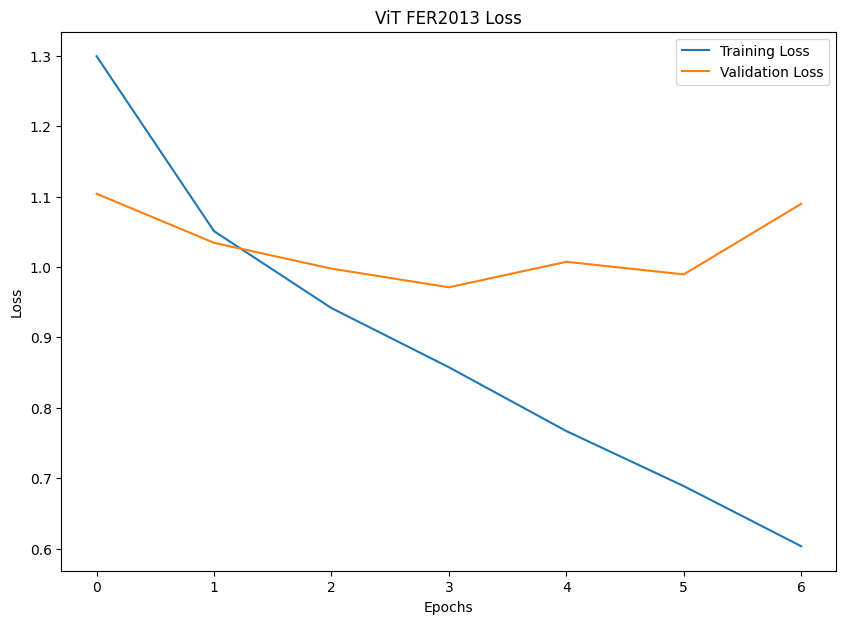

In [12]:
plot_losses(train_loss, val_loss, f'ViT {data.upper()} Loss')

In [13]:
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

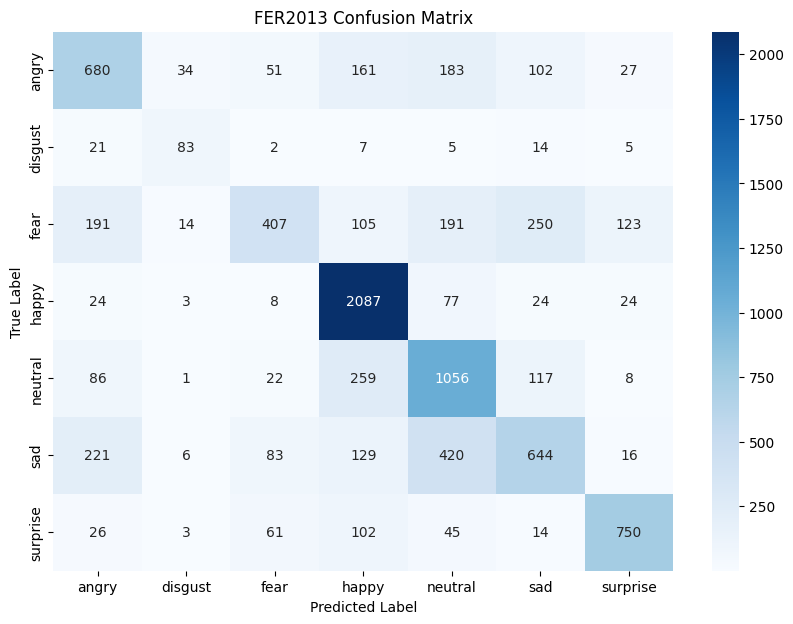

Test Accuracy: 0.6361
Precision: 0.6241
Recall: 0.6081
F1 Score: 0.6040
Classification Report:
               precision    recall  f1-score   support

       angry       0.54      0.55      0.55      1238
     disgust       0.58      0.61      0.59       137
        fear       0.64      0.32      0.43      1281
       happy       0.73      0.93      0.82      2247
     neutral       0.53      0.68      0.60      1549
         sad       0.55      0.42      0.48      1519
    surprise       0.79      0.75      0.77      1001

    accuracy                           0.64      8972
   macro avg       0.62      0.61      0.60      8972
weighted avg       0.63      0.64      0.62      8972



In [14]:
evaluate_transformer_model(model, 
                           test_loader, 
                           device, 
                           data, 
                           label_encoder=label_encoder)